In [ ]:
import os
import pandas as pd
import random
import requests
from tqdm import tqdm
from shutil import move

In [ ]:
!pip install torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.8MB/s]


Epoch 1/5, Loss: 0.2611128657601529
Epoch 2/5, Loss: 0.10161078992811307
Epoch 3/5, Loss: 0.07095215284318046
Epoch 4/5, Loss: 0.06164419605667777
Epoch 5/5, Loss: 0.0600890711856079


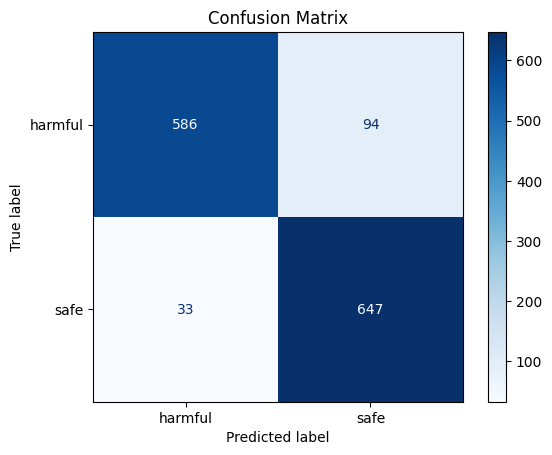

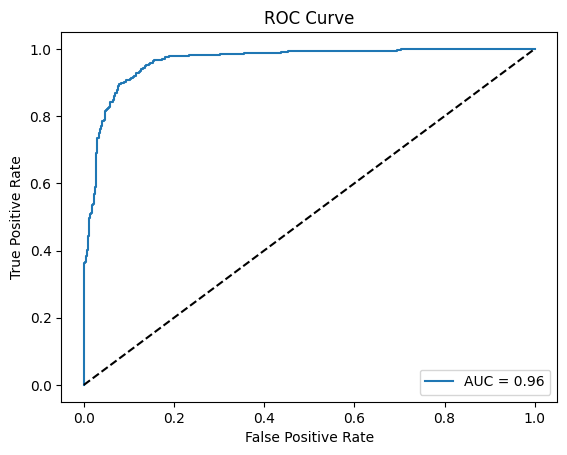

ROC AUC Score: 0.9633
Model saved to /content/drive/MyDrive/resnet50_harmful_safe.pth


In [ ]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
base_path = "/content/drive/MyDrive/openimages_dataset_small"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load data
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pretrained model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")


# Evaluation
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

model_path = "/content/drive/MyDrive/resnet50_harmful_safe.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


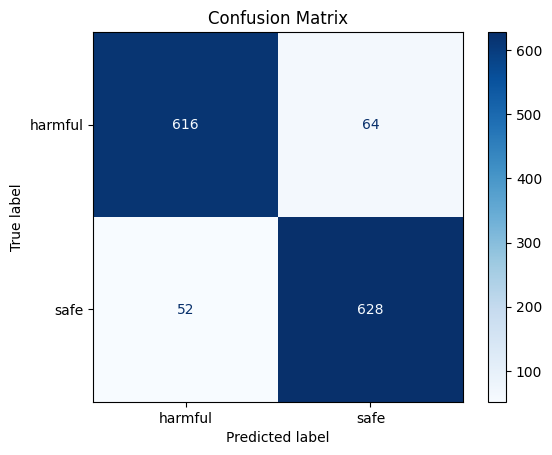

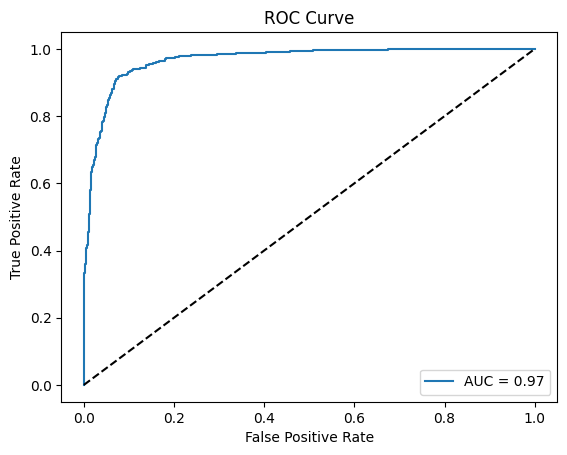

ROC AUC Score: 0.9665


In [ ]:
import os
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
base_path = "/content/drive/MyDrive/openimages_dataset_small"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load data
#train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
#train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pretrained model
# Load pretrained model and load trained weights
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_harmful_safe.pth"))

# Evaluation
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# model_path = "/content/drive/MyDrive/resnet50_harmful_safe.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

In [ ]:
import os
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
base_path = "/content/drive/MyDrive/openimages_dataset_small"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load data
#train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
#train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pretrained model
# Load pretrained model and load trained weights
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/mobilenetv2_simple.pth"))

# Evaluation
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# model_path = "/content/drive/MyDrive/resnet50_harmful_safe.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.0.1.num_batches_tracked", "features.1.conv.0.0.weight", "features.1.conv.0.1.weight", "features.1.conv.0.1.bias", "features.1.conv.0.1.running_mean", "features.1.conv.0.1.running_var", "features.1.conv.0.1.num_batches_tracked", "features.1.conv.1.weight", "features.1.conv.2.weight", "features.1.conv.2.bias", "features.1.conv.2.running_mean", "features.1.conv.2.running_var", "features.1.conv.2.num_batches_tracked", "features.2.conv.0.0.weight", "features.2.conv.0.1.weight", "features.2.conv.0.1.bias", "features.2.conv.0.1.running_mean", "features.2.conv.0.1.running_var", "features.2.conv.0.1.num_batches_tracked", "features.2.conv.1.0.weight", "features.2.conv.1.1.weight", "features.2.conv.1.1.bias", "features.2.conv.1.1.running_mean", "features.2.conv.1.1.running_var", "features.2.conv.1.1.num_batches_tracked", "features.2.conv.2.weight", "features.2.conv.3.weight", "features.2.conv.3.bias", "features.2.conv.3.running_mean", "features.2.conv.3.running_var", "features.2.conv.3.num_batches_tracked", "features.3.conv.0.0.weight", "features.3.conv.0.1.weight", "features.3.conv.0.1.bias", "features.3.conv.0.1.running_mean", "features.3.conv.0.1.running_var", "features.3.conv.0.1.num_batches_tracked", "features.3.conv.1.0.weight", "features.3.conv.1.1.weight", "features.3.conv.1.1.bias", "features.3.conv.1.1.running_mean", "features.3.conv.1.1.running_var", "features.3.conv.1.1.num_batches_tracked", "features.3.conv.2.weight", "features.3.conv.3.weight", "features.3.conv.3.bias", "features.3.conv.3.running_mean", "features.3.conv.3.running_var", "features.3.conv.3.num_batches_tracked", "features.4.conv.0.0.weight", "features.4.conv.0.1.weight", "features.4.conv.0.1.bias", "features.4.conv.0.1.running_mean", "features.4.conv.0.1.running_var", "features.4.conv.0.1.num_batches_tracked", "features.4.conv.1.0.weight", "features.4.conv.1.1.weight", "features.4.conv.1.1.bias", "features.4.conv.1.1.running_mean", "features.4.conv.1.1.running_var", "features.4.conv.1.1.num_batches_tracked", "features.4.conv.2.weight", "features.4.conv.3.weight", "features.4.conv.3.bias", "features.4.conv.3.running_mean", "features.4.conv.3.running_var", "features.4.conv.3.num_batches_tracked", "features.5.conv.0.0.weight", "features.5.conv.0.1.weight", "features.5.conv.0.1.bias", "features.5.conv.0.1.running_mean", "features.5.conv.0.1.running_var", "features.5.conv.0.1.num_batches_tracked", "features.5.conv.1.0.weight", "features.5.conv.1.1.weight", "features.5.conv.1.1.bias", "features.5.conv.1.1.running_mean", "features.5.conv.1.1.running_var", "features.5.conv.1.1.num_batches_tracked", "features.5.conv.2.weight", "features.5.conv.3.weight", "features.5.conv.3.bias", "features.5.conv.3.running_mean", "features.5.conv.3.running_var", "features.5.conv.3.num_batches_tracked", "features.6.conv.0.0.weight", "features.6.conv.0.1.weight", "features.6.conv.0.1.bias", "features.6.conv.0.1.running_mean", "features.6.conv.0.1.running_var", "features.6.conv.0.1.num_batches_tracked", "features.6.conv.1.0.weight", "features.6.conv.1.1.weight", "features.6.conv.1.1.bias", "features.6.conv.1.1.running_mean", "features.6.conv.1.1.running_var", "features.6.conv.1.1.num_batches_tracked", "features.6.conv.2.weight", "features.6.conv.3.weight", "features.6.conv.3.bias", "features.6.conv.3.running_mean", "features.6.conv.3.running_var", "features.6.conv.3.num_batches_tracked", "features.7.conv.0.0.weight", "features.7.conv.0.1.weight", "features.7.conv.0.1.bias", "features.7.conv.0.1.running_mean", "features.7.conv.0.1.running_var", "features.7.conv.0.1.num_batches_tracked", "features.7.conv.1.0.weight", "features.7.conv.1.1.weight", "features.7.conv.1.1.bias", "features.7.conv.1.1.running_mean", "features.7.conv.1.1.running_var", "features.7.conv.1.1.num_batches_tracked", "features.7.conv.2.weight", "features.7.conv.3.weight", "features.7.conv.3.bias", "features.7.conv.3.running_mean", "features.7.conv.3.running_var", "features.7.conv.3.num_batches_tracked", "features.8.conv.0.0.weight", "features.8.conv.0.1.weight", "features.8.conv.0.1.bias", "features.8.conv.0.1.running_mean", "features.8.conv.0.1.running_var", "features.8.conv.0.1.num_batches_tracked", "features.8.conv.1.0.weight", "features.8.conv.1.1.weight", "features.8.conv.1.1.bias", "features.8.conv.1.1.running_mean", "features.8.conv.1.1.running_var", "features.8.conv.1.1.num_batches_tracked", "features.8.conv.2.weight", "features.8.conv.3.weight", "features.8.conv.3.bias", "features.8.conv.3.running_mean", "features.8.conv.3.running_var", "features.8.conv.3.num_batches_tracked", "features.9.conv.0.0.weight", "features.9.conv.0.1.weight", "features.9.conv.0.1.bias", "features.9.conv.0.1.running_mean", "features.9.conv.0.1.running_var", "features.9.conv.0.1.num_batches_tracked", "features.9.conv.1.0.weight", "features.9.conv.1.1.weight", "features.9.conv.1.1.bias", "features.9.conv.1.1.running_mean", "features.9.conv.1.1.running_var", "features.9.conv.1.1.num_batches_tracked", "features.9.conv.2.weight", "features.9.conv.3.weight", "features.9.conv.3.bias", "features.9.conv.3.running_mean", "features.9.conv.3.running_var", "features.9.conv.3.num_batches_tracked", "features.10.conv.0.0.weight", "features.10.conv.0.1.weight", "features.10.conv.0.1.bias", "features.10.conv.0.1.running_mean", "features.10.conv.0.1.running_var", "features.10.conv.0.1.num_batches_tracked", "features.10.conv.1.0.weight", "features.10.conv.1.1.weight", "features.10.conv.1.1.bias", "features.10.conv.1.1.running_mean", "features.10.conv.1.1.running_var", "features.10.conv.1.1.num_batches_tracked", "features.10.conv.2.weight", "features.10.conv.3.weight", "features.10.conv.3.bias", "features.10.conv.3.running_mean", "features.10.conv.3.running_var", "features.10.conv.3.num_batches_tracked", "features.11.conv.0.0.weight", "features.11.conv.0.1.weight", "features.11.conv.0.1.bias", "features.11.conv.0.1.running_mean", "features.11.conv.0.1.running_var", "features.11.conv.0.1.num_batches_tracked", "features.11.conv.1.0.weight", "features.11.conv.1.1.weight", "features.11.conv.1.1.bias", "features.11.conv.1.1.running_mean", "features.11.conv.1.1.running_var", "features.11.conv.1.1.num_batches_tracked", "features.11.conv.2.weight", "features.11.conv.3.weight", "features.11.conv.3.bias", "features.11.conv.3.running_mean", "features.11.conv.3.running_var", "features.11.conv.3.num_batches_tracked", "features.12.conv.0.0.weight", "features.12.conv.0.1.weight", "features.12.conv.0.1.bias", "features.12.conv.0.1.running_mean", "features.12.conv.0.1.running_var", "features.12.conv.0.1.num_batches_tracked", "features.12.conv.1.0.weight", "features.12.conv.1.1.weight", "features.12.conv.1.1.bias", "features.12.conv.1.1.running_mean", "features.12.conv.1.1.running_var", "features.12.conv.1.1.num_batches_tracked", "features.12.conv.2.weight", "features.12.conv.3.weight", "features.12.conv.3.bias", "features.12.conv.3.running_mean", "features.12.conv.3.running_var", "features.12.conv.3.num_batches_tracked", "features.13.conv.0.0.weight", "features.13.conv.0.1.weight", "features.13.conv.0.1.bias", "features.13.conv.0.1.running_mean", "features.13.conv.0.1.running_var", "features.13.conv.0.1.num_batches_tracked", "features.13.conv.1.0.weight", "features.13.conv.1.1.weight", "features.13.conv.1.1.bias", "features.13.conv.1.1.running_mean", "features.13.conv.1.1.running_var", "features.13.conv.1.1.num_batches_tracked", "features.13.conv.2.weight", "features.13.conv.3.weight", "features.13.conv.3.bias", "features.13.conv.3.running_mean", "features.13.conv.3.running_var", "features.13.conv.3.num_batches_tracked", "features.14.conv.0.0.weight", "features.14.conv.0.1.weight", "features.14.conv.0.1.bias", "features.14.conv.0.1.running_mean", "features.14.conv.0.1.running_var", "features.14.conv.0.1.num_batches_tracked", "features.14.conv.1.0.weight", "features.14.conv.1.1.weight", "features.14.conv.1.1.bias", "features.14.conv.1.1.running_mean", "features.14.conv.1.1.running_var", "features.14.conv.1.1.num_batches_tracked", "features.14.conv.2.weight", "features.14.conv.3.weight", "features.14.conv.3.bias", "features.14.conv.3.running_mean", "features.14.conv.3.running_var", "features.14.conv.3.num_batches_tracked", "features.15.conv.0.0.weight", "features.15.conv.0.1.weight", "features.15.conv.0.1.bias", "features.15.conv.0.1.running_mean", "features.15.conv.0.1.running_var", "features.15.conv.0.1.num_batches_tracked", "features.15.conv.1.0.weight", "features.15.conv.1.1.weight", "features.15.conv.1.1.bias", "features.15.conv.1.1.running_mean", "features.15.conv.1.1.running_var", "features.15.conv.1.1.num_batches_tracked", "features.15.conv.2.weight", "features.15.conv.3.weight", "features.15.conv.3.bias", "features.15.conv.3.running_mean", "features.15.conv.3.running_var", "features.15.conv.3.num_batches_tracked", "features.16.conv.0.0.weight", "features.16.conv.0.1.weight", "features.16.conv.0.1.bias", "features.16.conv.0.1.running_mean", "features.16.conv.0.1.running_var", "features.16.conv.0.1.num_batches_tracked", "features.16.conv.1.0.weight", "features.16.conv.1.1.weight", "features.16.conv.1.1.bias", "features.16.conv.1.1.running_mean", "features.16.conv.1.1.running_var", "features.16.conv.1.1.num_batches_tracked", "features.16.conv.2.weight", "features.16.conv.3.weight", "features.16.conv.3.bias", "features.16.conv.3.running_mean", "features.16.conv.3.running_var", "features.16.conv.3.num_batches_tracked", "features.17.conv.0.0.weight", "features.17.conv.0.1.weight", "features.17.conv.0.1.bias", "features.17.conv.0.1.running_mean", "features.17.conv.0.1.running_var", "features.17.conv.0.1.num_batches_tracked", "features.17.conv.1.0.weight", "features.17.conv.1.1.weight", "features.17.conv.1.1.bias", "features.17.conv.1.1.running_mean", "features.17.conv.1.1.running_var", "features.17.conv.1.1.num_batches_tracked", "features.17.conv.2.weight", "features.17.conv.3.weight", "features.17.conv.3.bias", "features.17.conv.3.running_mean", "features.17.conv.3.running_var", "features.17.conv.3.num_batches_tracked", "features.18.0.weight", "features.18.1.weight", "features.18.1.bias", "features.18.1.running_mean", "features.18.1.running_var", "features.18.1.num_batches_tracked", "classifier.1.weight", "classifier.1.bias". 

In [ ]:
# Load data
#train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
#train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# --- Validation Function ---
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

def validate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability for harmful class

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = None

    print(f"✅ Validation Accuracy: {acc:.4f}")
    print(f"✅ Validation Precision: {precision:.4f}")
    if roc_auc is not None:
        print(f"✅ Validation ROC-AUC: {roc_auc:.4f}")
    else:
        print("⚠️ ROC-AUC could not be calculated (only one class predicted).")

    return acc, precision, roc_auc

# --- Run Validation ---
validate_model(model, val_loader, device)

# Evaluation Metrics

              precision    recall  f1-score   support

     harmful       0.92      0.91      0.91       680
        safe       0.91      0.92      0.92       680

    accuracy                           0.91      1360
   macro avg       0.91      0.91      0.91      1360
weighted avg       0.91      0.91      0.91      1360



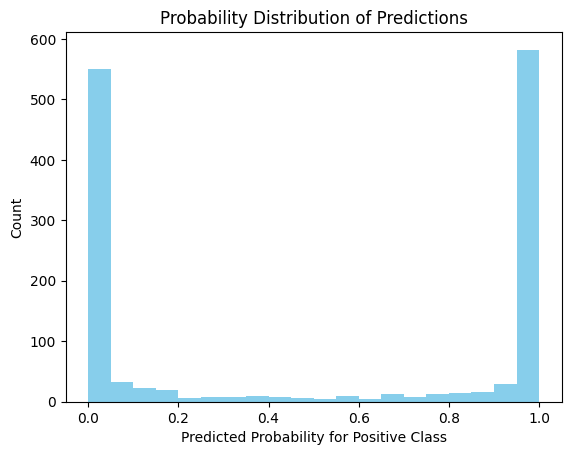

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

plt.hist(y_probs, bins=20, color='skyblue')
plt.xlabel("Predicted Probability for Positive Class")
plt.ylabel("Count")
plt.title("Probability Distribution of Predictions")
plt.show()

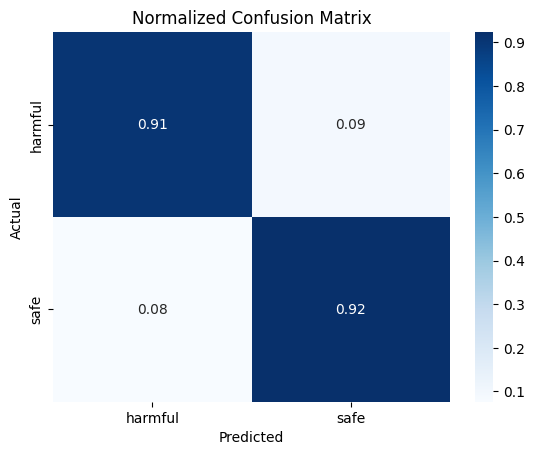

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=train_data.classes, yticklabels=train_data.classes, cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

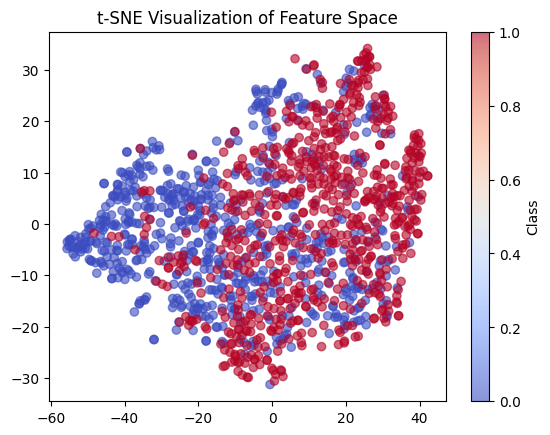

In [ ]:
from sklearn.manifold import TSNE

model.eval()
features, labels = [], []
with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        x = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(images))))))))
        x = torch.flatten(x, 1)
        features.append(x.cpu())
        labels.extend(label.numpy())

features = torch.cat(features).numpy()
tsne = TSNE(n_components=2).fit_transform(features)

plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of Feature Space")
plt.colorbar(label="Class")
plt.show()

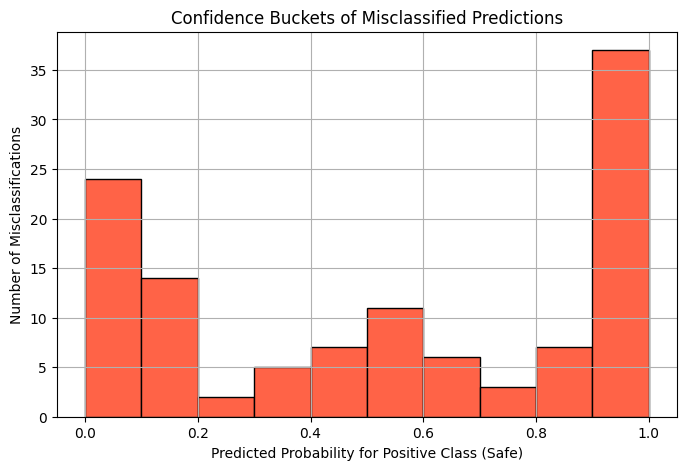

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true, y_pred, y_probs (from evaluation phase)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Get misclassified predictions
misclassified_mask = y_true != y_pred
misclassified_probs = y_probs[misclassified_mask]

# Plot histogram of predicted probabilities for misclassified samples
plt.figure(figsize=(8, 5))
plt.hist(misclassified_probs, bins=np.linspace(0, 1, 11), color='tomato', edgecolor='black')
plt.xlabel("Predicted Probability for Positive Class (Safe)")
plt.ylabel("Number of Misclassifications")
plt.title("Confidence Buckets of Misclassified Predictions")
plt.grid(True)
plt.show()


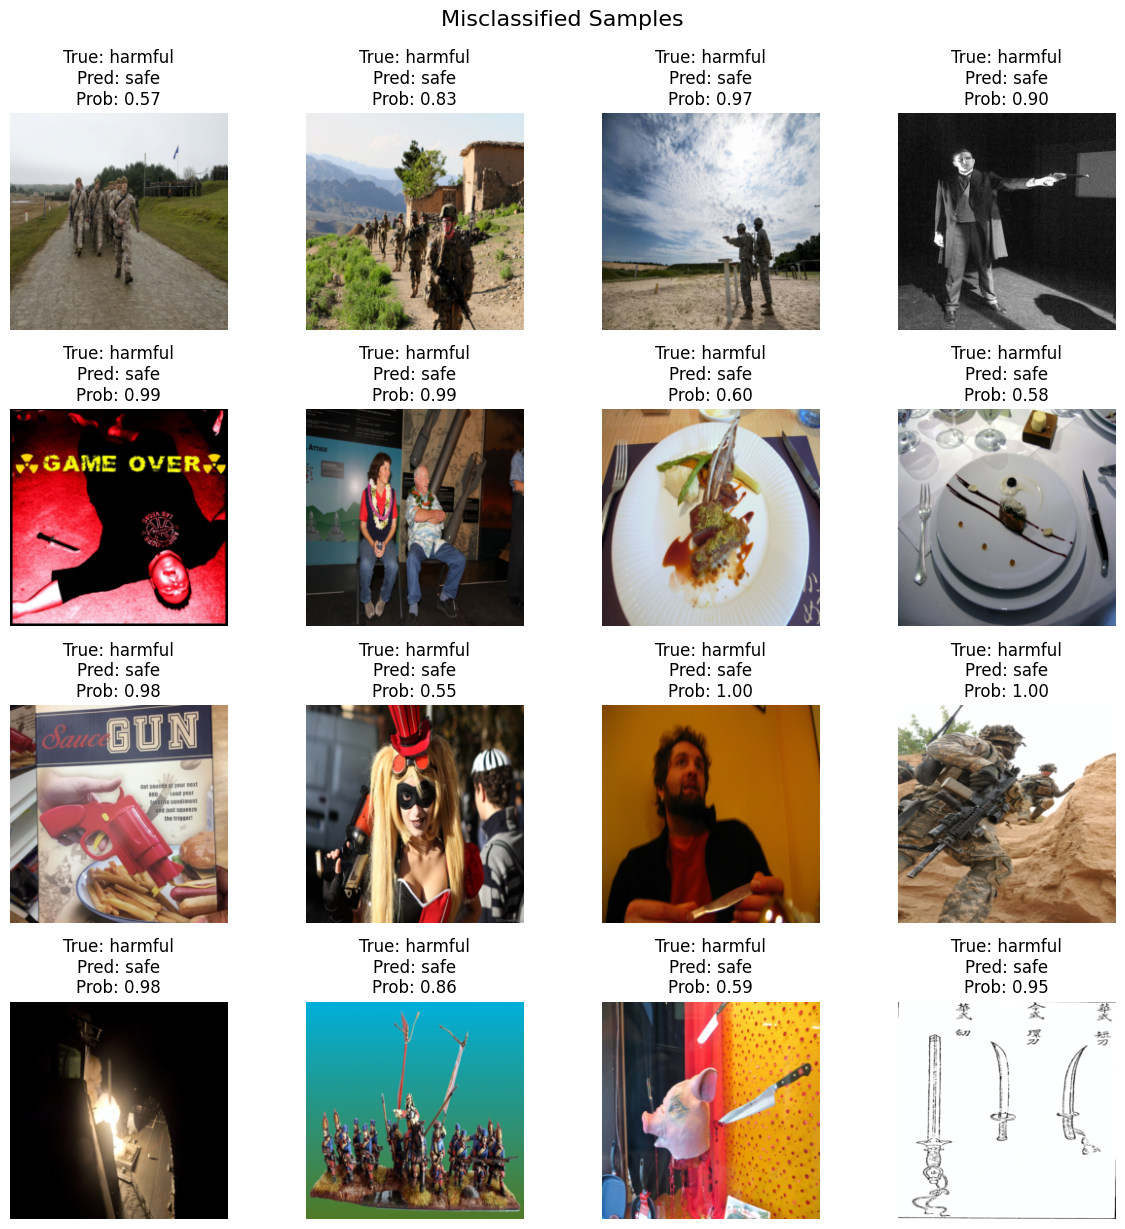

In [ ]:
# Record misclassified images and related information
wrong_images = []
wrong_preds = []
wrong_labels = []
wrong_probs = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Identify incorrect predictions
        wrong_mask = preds != labels
        if wrong_mask.any():
            wrong_images.append(images[wrong_mask].cpu())
            wrong_preds.extend(preds[wrong_mask].cpu().numpy())
            wrong_labels.extend(labels[wrong_mask].cpu().numpy())
            wrong_probs.extend(probs[wrong_mask, 1].cpu().numpy())

# Concatenate misclassified images (show up to 16)
wrong_images = torch.cat(wrong_images, dim=0)
num_show = min(16, len(wrong_images))

# Display misclassified images
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(num_show):
    img = wrong_images[i].permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) +
                  np.array([0.485, 0.456, 0.406]), 0, 1)  # unnormalize

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {train_data.classes[wrong_labels[i]]}\nPred: {train_data.classes[wrong_preds[i]]}\nProb: {wrong_probs[i]:.2f}")

plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=16, y=1.02)
plt.show()